In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Classifying Emotion in Audio Clips

Analyzing audio recordings and identify the emotions expressed in the speech

## Reading Datasets

In [3]:
curr_dir = os.getcwd()

ravdess_path = os.path.join(curr_dir, "data_ravdess")
crema_path = os.path.join(curr_dir, "data_crema")
tess_path = os.path.join(curr_dir, "data_tess")
savee_path = os.path.join(curr_dir, "data_savee")

### Ravdess

The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

In [4]:
# ravdess key:value pairs 
emotions_convert = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprise'
}

In [5]:
data = []

# Process files and store relevant data
for actor in os.listdir(ravdess_path):
    if 'Actor' in actor:
        actor_folder_path = os.path.join(ravdess_path, actor)
        for audio_file in os.listdir(actor_folder_path):
            file_name = audio_file.split('.')[0]
            parts = file_name.split('-')

            emotion_key = parts[2]
            gender_identifier = int(parts[6])
            gender = 'female' if gender_identifier % 2 == 0 else 'male'

            # Store each row's data as a dictionary
            data.append({
                'Path': os.path.join(actor_folder_path, audio_file),
                'Sex': gender,
                'Emotion': emotions_convert.get(emotion_key, 'Unknown')  # Use get to handle missing keys
            })

# Create DataFrame from the list of dictionaries
Ravdess_df = pd.DataFrame(data)

Ravdess_df

Path     Sex  Emotion
0     /Users/gabrielcha/Documents/ser/data_ravdess/A...  female    angry
1     /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     fear
2     /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     fear
3     /Users/gabrielcha/Documents/ser/data_ravdess/A...  female    angry
4     /Users/gabrielcha/Documents/ser/data_ravdess/A...  female  disgust
...                                                 ...     ...      ...
1435  /Users/gabrielcha/Documents/ser/data_ravdess/A...  female    happy
1436  /Users/gabrielcha/Documents/ser/data_ravdess/A...  female    happy
1437  /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     calm
1438  /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     calm
1439  /Users/gabrielcha/Documents/ser/data_ravdess/A...  female  neutral

[1440 rows x 3 columns]

### Crema

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [6]:
# crema key:value pairs 
emotion_mapping = {
    'SAD': 'sad',
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral'
}

# actor's info
crema_actor_info = pd.read_csv('VideoDemographics.csv', usecols=['ActorID', 'Sex'])

In [7]:
data = []

# Process files and store relevant data
for file in os.listdir(crema_path):
    file_path = os.path.join(crema_path, file)
    parts = file.split('_')
    actor_info = parts[0]
    emotion_code = parts[2]

    # Append each row's data as a dictionary
    data.append({
        'Path': file_path,
        'ActorID': actor_info,
        'Emotion': emotion_mapping.get(emotion_code, 'Unknown')  # Handle unknown emotions
    })

# Create DataFrame from the list of dictionaries
Crema_df = pd.DataFrame(data)

# retrieve actor's info
Crema_df['ActorID'] = Crema_df['ActorID'].astype(int)
merged_df = pd.merge(Crema_df, crema_actor_info, left_on = 'ActorID', right_on = 'ActorID', how = 'left')
Crema_df = merged_df[['Path', 'Emotion', 'Sex']]
Crema_df['Sex'] = Crema_df['Sex'].str.lower()

Crema_df

Path  Emotion     Sex
0     /Users/gabrielcha/Documents/ser/data_crema/102...    angry    male
1     /Users/gabrielcha/Documents/ser/data_crema/103...    angry  female
2     /Users/gabrielcha/Documents/ser/data_crema/106...  neutral  female
3     /Users/gabrielcha/Documents/ser/data_crema/107...  neutral  female
4     /Users/gabrielcha/Documents/ser/data_crema/107...  disgust  female
...                                                 ...      ...     ...
7437  /Users/gabrielcha/Documents/ser/data_crema/108...    angry  female
7438  /Users/gabrielcha/Documents/ser/data_crema/102...    angry  female
7439  /Users/gabrielcha/Documents/ser/data_crema/103...    angry  female
7440  /Users/gabrielcha/Documents/ser/data_crema/101...    angry    male
7441  /Users/gabrielcha/Documents/ser/data_crema/107...  neutral  female

[7442 rows x 3 columns]

### Tess

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format



In [8]:
data = []

# Process files and store relevant data
for dir_name in os.listdir(tess_path):
    dir_path = os.path.join(tess_path, dir_name)
    for file in os.listdir(dir_path):
        # print(file)
        file_name = file.split('.')[0]
        parts = file_name.split('_')
        if len(parts) > 2:
            emotion_part = parts[2]
            if emotion_part=='ps': emotion = 'surprise'
            else: emotion = emotion_part
            # Append each row's data as a dictionary
            data.append({
                'Path': os.path.join(dir_path, file),
                'Emotion': emotion, 
                'Sex': 'female'
            })

# Create DataFrame from the list of dictionaries
Tess_df = pd.DataFrame(data)

Tess_df

Path  Emotion     Sex
0     /Users/gabrielcha/Documents/ser/data_tess/YAF_...  disgust  female
1     /Users/gabrielcha/Documents/ser/data_tess/YAF_...  disgust  female
2     /Users/gabrielcha/Documents/ser/data_tess/YAF_...  disgust  female
3     /Users/gabrielcha/Documents/ser/data_tess/YAF_...  disgust  female
4     /Users/gabrielcha/Documents/ser/data_tess/YAF_...  disgust  female
...                                                 ...      ...     ...
2795  /Users/gabrielcha/Documents/ser/data_tess/OAF_...      sad  female
2796  /Users/gabrielcha/Documents/ser/data_tess/OAF_...      sad  female
2797  /Users/gabrielcha/Documents/ser/data_tess/OAF_...      sad  female
2798  /Users/gabrielcha/Documents/ser/data_tess/OAF_...      sad  female
2799  /Users/gabrielcha/Documents/ser/data_tess/OAF_...      sad  female

[2800 rows x 3 columns]

### Savee 

The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. A neutral category is also added to provide recordings of 7 emotion categories.

In [9]:
# dictionary to map short emotion codes to full names
emotion_mapping = {
    'a': 'angry',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    'sa': 'sad',
    'su': 'surprise'  
}

In [10]:
data = []


for file in os.listdir(savee_path):
    file_path = os.path.join(savee_path, file)
    part = file.split('_')[1][:-6]  # Get the emotion code, trimming the last 6 characters

    # Use the dictionary to get the full emotion name, default to 'surprise' if not found
    emotion = emotion_mapping.get(part, 'surprise')
    
    # Append each row's data as a dictionary
    data.append({
        'Path': file_path,
        'Emotion': emotion,
        'Sex' : 'male'
    })

# Create DataFrame from the list of dictionaries
Savee_df = pd.DataFrame(data)

Savee_df

Path   Emotion   Sex
0    /Users/gabrielcha/Documents/ser/data_savee/JK_...       sad  male
1    /Users/gabrielcha/Documents/ser/data_savee/JK_...       sad  male
2    /Users/gabrielcha/Documents/ser/data_savee/DC_...   neutral  male
3    /Users/gabrielcha/Documents/ser/data_savee/DC_...  surprise  male
4    /Users/gabrielcha/Documents/ser/data_savee/DC_...   neutral  male
..                                                 ...       ...   ...
475  /Users/gabrielcha/Documents/ser/data_savee/JE_...     angry  male
476  /Users/gabrielcha/Documents/ser/data_savee/JE_...     angry  male
477  /Users/gabrielcha/Documents/ser/data_savee/DC_...   neutral  male
478  /Users/gabrielcha/Documents/ser/data_savee/DC_...  surprise  male
479  /Users/gabrielcha/Documents/ser/data_savee/DC_...  surprise  male

[480 rows x 3 columns]

## Audio Files

In [11]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
dataset = data_path.reset_index(drop=['index'])
dataset.to_csv("data_path.csv",index=False)
dataset['Emotion'] = dataset['Emotion'].replace('surprised', 'surprise')
dataset

Path     Sex   Emotion
0      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     angry
1      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female      fear
2      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female      fear
3      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     angry
4      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female   disgust
...                                                  ...     ...       ...
12157  /Users/gabrielcha/Documents/ser/data_savee/JE_...    male     angry
12158  /Users/gabrielcha/Documents/ser/data_savee/JE_...    male     angry
12159  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male   neutral
12160  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male  surprise
12161  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male  surprise

[12162 rows x 3 columns]

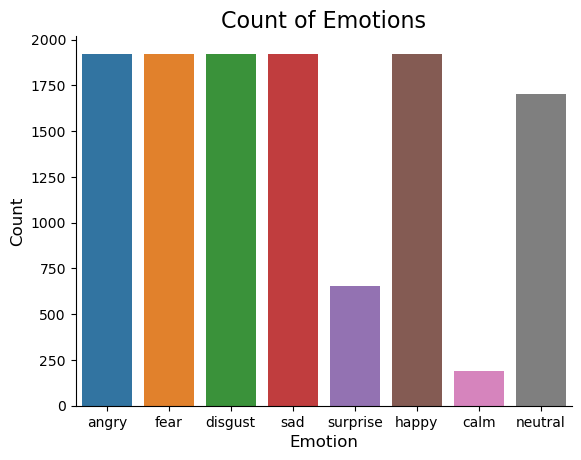

In [17]:
# plt.figure(figsize=(10, 10))
plt.title('Count of Emotions', size=16)
sns.countplot(dataset.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotion', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [18]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

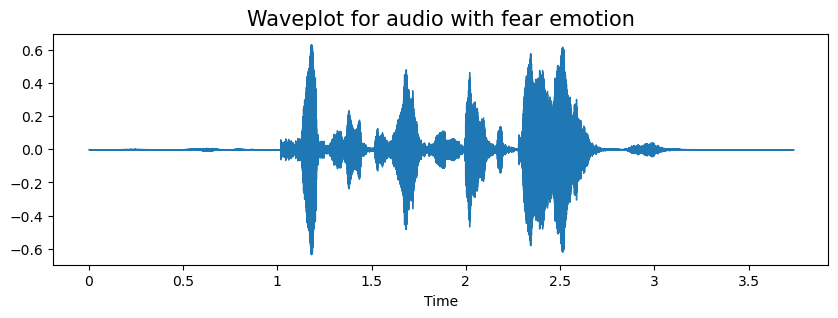

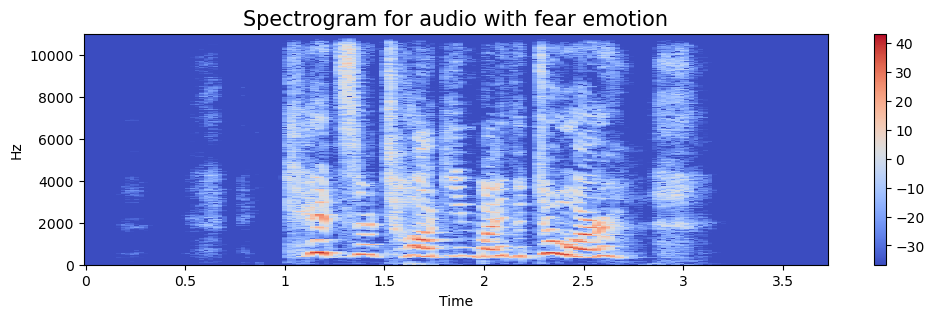

In [19]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


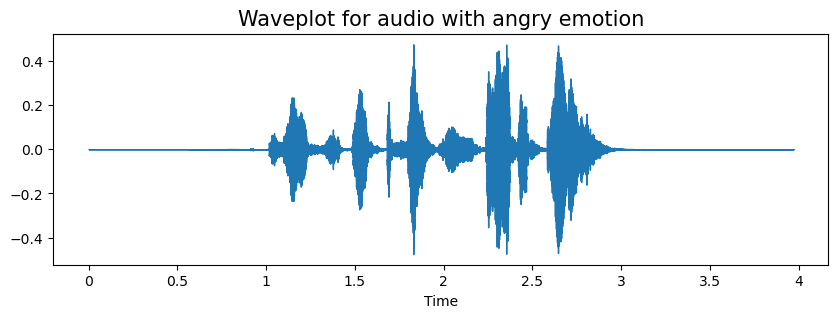

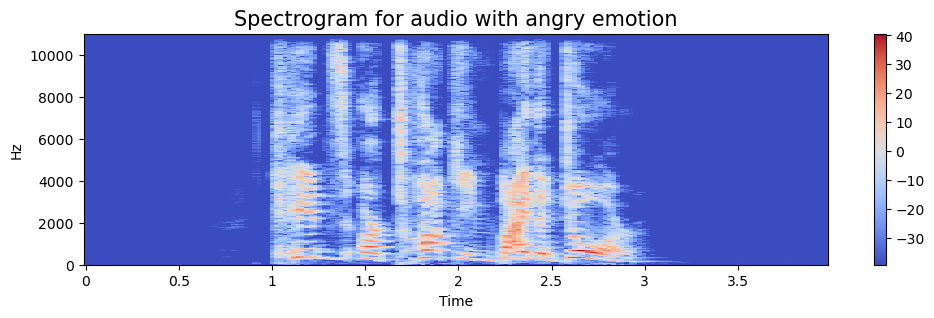

In [20]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

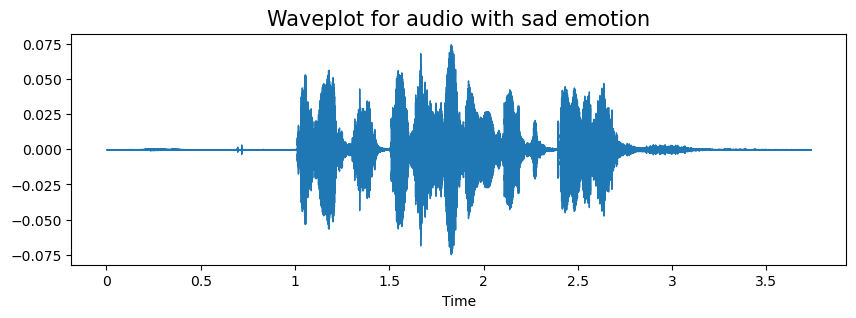

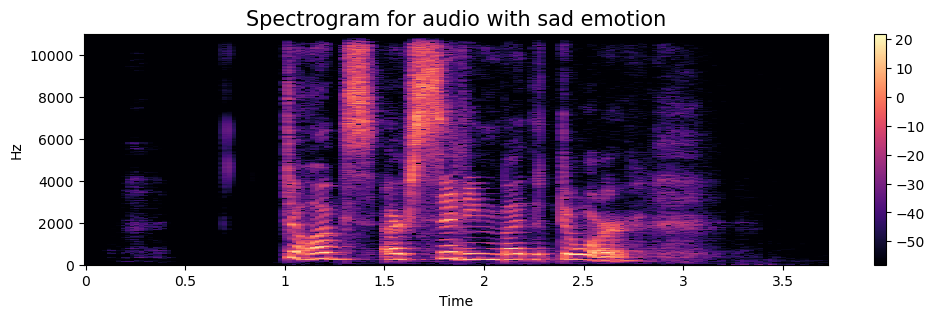

In [21]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

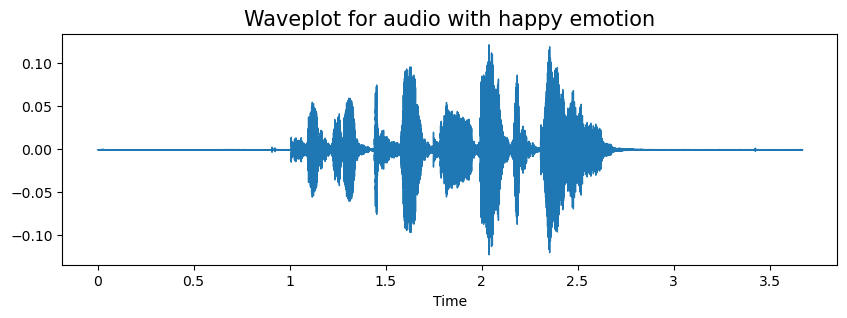

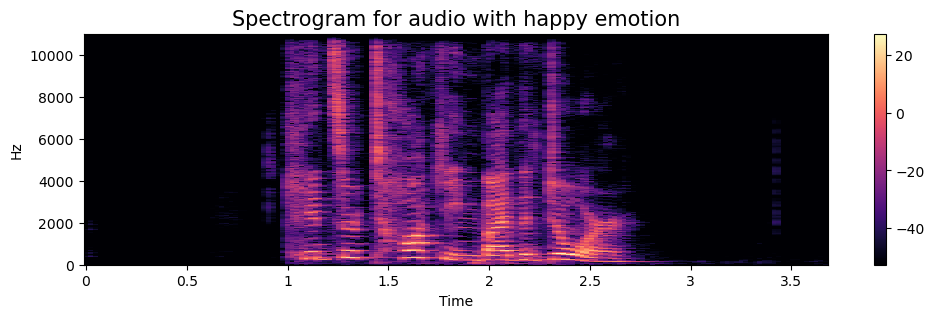

In [22]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

In [23]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate1=0.8):
    return librosa.effects.time_stretch(data, rate = rate1)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

#not using pitch
def pitch(data, sampling_rate, pitch_factor1=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor = pitch_factor1)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)



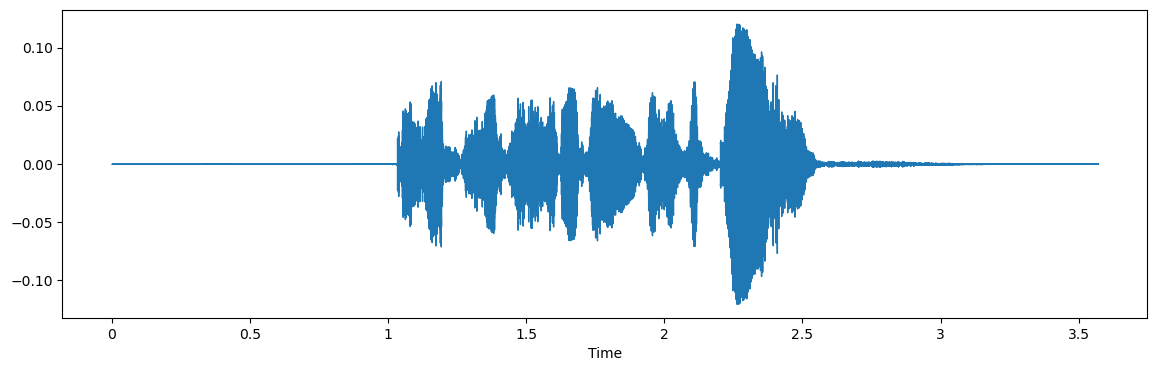

In [24]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

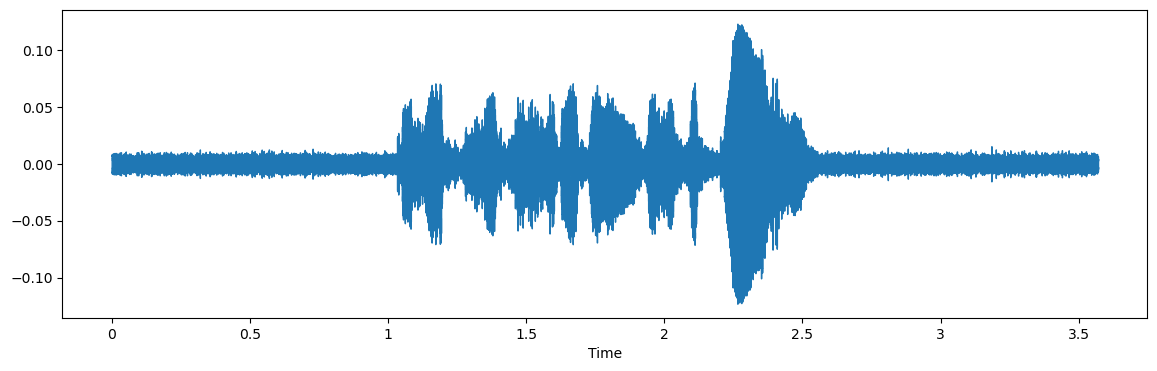

In [25]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

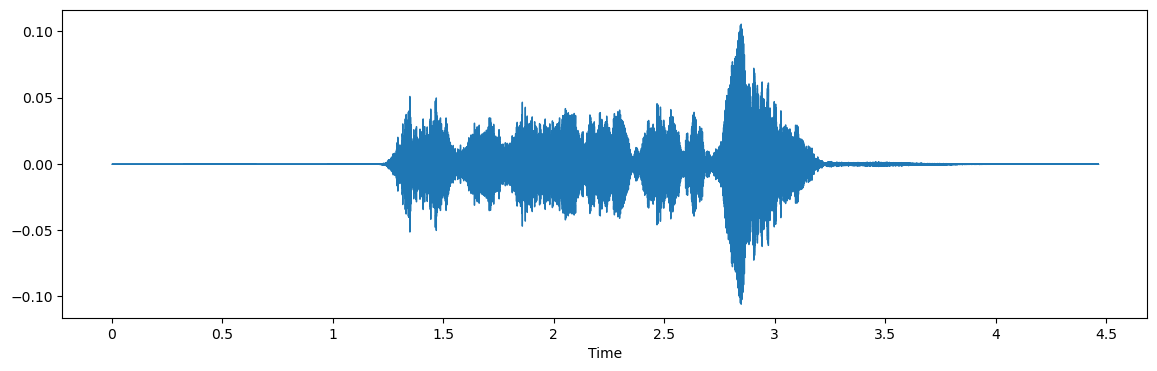

In [26]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

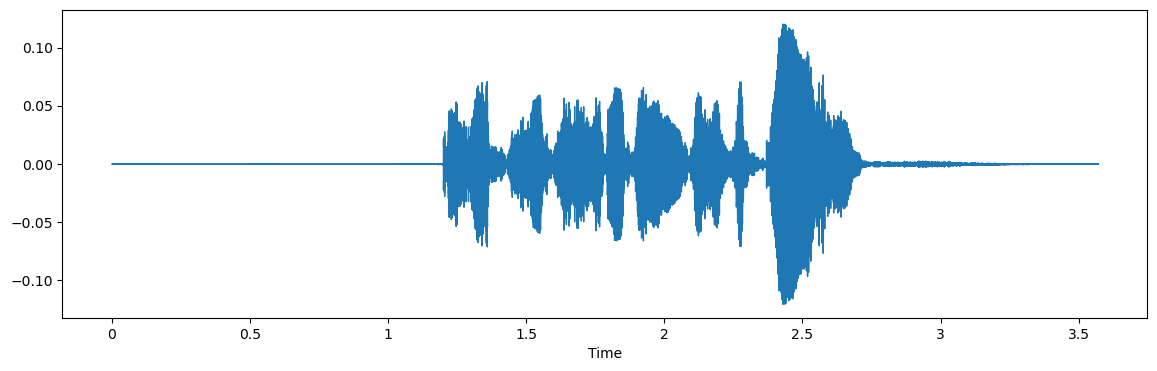

In [27]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

In [28]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [29]:
path = df['path'].loc[0]

data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

result = np.array([])


# Chroma_stft
stft = np.abs(librosa.stft(data))
chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
result = np.hstack((result, chroma_stft)) # stacking horizontally

NameError: name 'df' is not defined

In [ ]:

# without augmentation
res1 = extract_features(data)

# Chroma_stft
stft = np.abs(librosa.stft(data))


chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
result = np.hstack((result, chroma_stft)) # stacking horizontally

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    #data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(new_data)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [154]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [33]:
Features = pd.read_csv('features.csv')
# Features['labels'] = Y
# Features.to_csv('features.csv', index=False)
# Features.head()

In [34]:
Features = Features.sample(frac=1).reset_index(drop=True) 

In [35]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [36]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [37]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [38]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [39]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

In [40]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

2024-06-02 13:09:51.020802: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-02 13:09:51.020848: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-06-02 13:09:51.020861: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-06-02 13:09:51.021046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-02 13:09:51.021072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [41]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


2024-06-02 13:09:51.794944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - ETA: 0s - loss: 2.1056 - accuracy: 0.2485

2024-06-02 13:09:58.820749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - 8s 16ms/step - loss: 2.1056 - accuracy: 0.2485 - val_loss: 1.6656 - val_accuracy: 0.3433 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 7s 15ms/step - loss: 1.8227 - accuracy: 0.3309 - val_loss: 1.4766 - val_accuracy: 0.3990 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 6s 15ms/step - loss: 1.6000 - accuracy: 0.3863 - val_loss: 1.3773 - val_accuracy: 0.4606 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 7s 15ms/step - loss: 1.4583 - accuracy: 0.4296 - val_loss: 1.3856 - val_accuracy: 0.4569 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 7s 16ms/step - loss: 1.4216 - accuracy: 0.4431 - val_loss: 1.2699 - val_accuracy: 0.5005 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 7s 15ms/step - loss: 1.3781 - accuracy: 0.4650 - val_loss: 1.2607 - val_accuracy: 0.4992 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 7s 15ms/step - loss: 

286/286 [==============================] - 2s 8ms/step - loss: 1.2983 - accuracy: 0.4980
Accuracy of our model on test data :  49.80267584323883 %


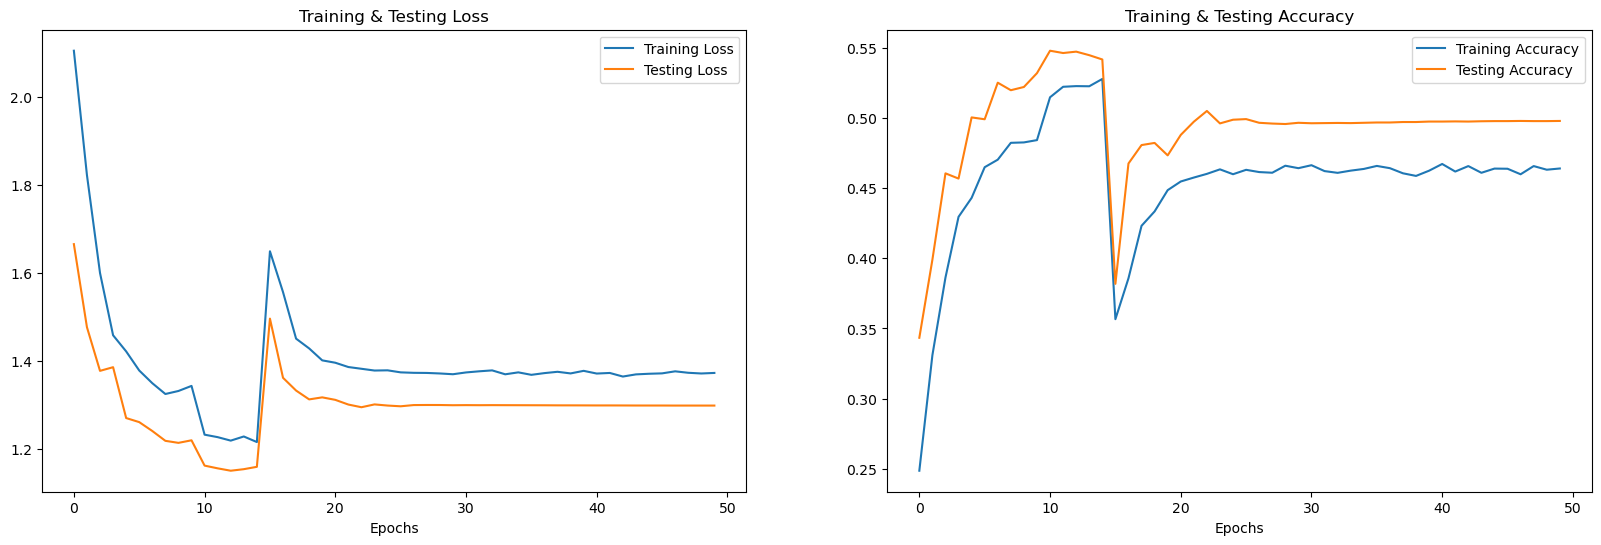

In [42]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [43]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

 44/286 [===>..........................] - ETA: 0s

2024-06-02 13:15:33.909391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - 1s 3ms/step


In [44]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1            angry         happy
2          disgust       disgust
3              sad          fear
4            happy           sad
5             fear          fear
6             fear         happy
7             fear          fear
8          disgust       disgust
9            angry         angry

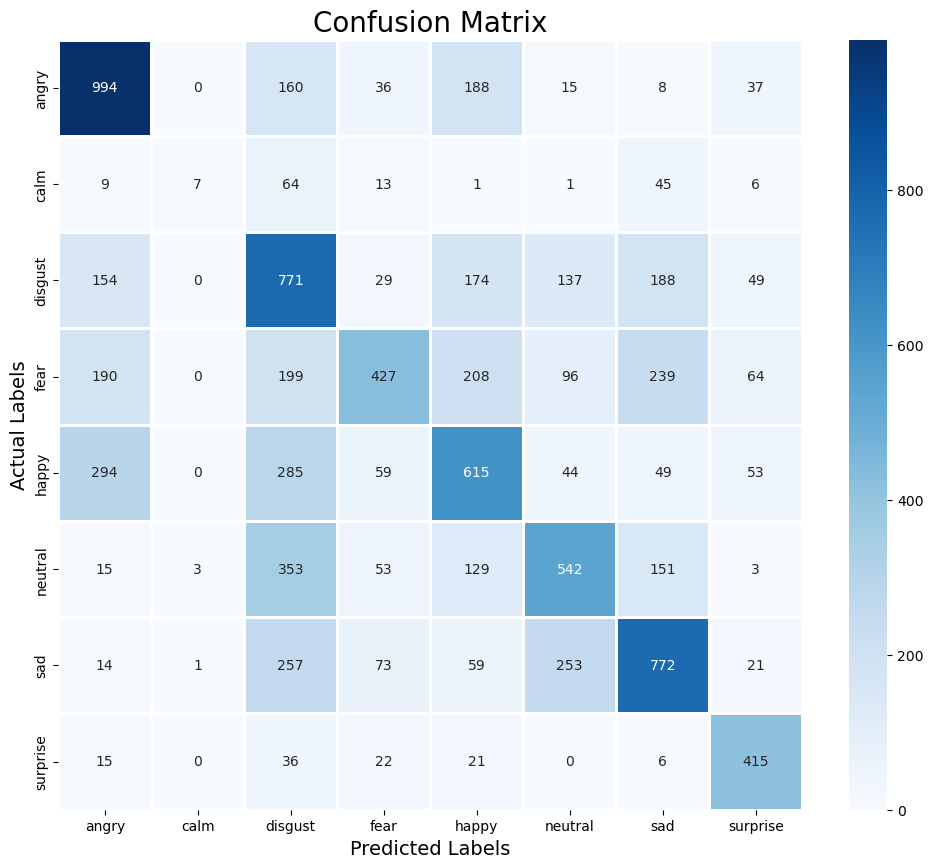

In [45]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.59      0.69      0.64      1438
        calm       0.64      0.05      0.09       146
     disgust       0.36      0.51      0.43      1502
        fear       0.60      0.30      0.40      1423
       happy       0.44      0.44      0.44      1399
     neutral       0.50      0.43      0.46      1249
         sad       0.53      0.53      0.53      1450
    surprise       0.64      0.81      0.71       515

    accuracy                           0.50      9122
   macro avg       0.54      0.47      0.46      9122
weighted avg       0.51      0.50      0.49      9122



## Second Model

In [47]:
Features = Features.sample(frac=1).reset_index(drop=True) 

In [48]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [49]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [50]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [51]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

In [52]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=1e-6)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 activation (Activation)     (None, 162, 256)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 162, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 162, 128)          0         
                                                                 
 dropout_2 (Dropout)         (None, 162, 128)          0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 20, 128)           0         
 g1D)                                                            
                                                      

In [54]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [55]:
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50


2024-06-02 13:15:35.595556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - ETA: 0s - loss: 1.3591 - accuracy: 0.4698

2024-06-02 13:15:41.602708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - 7s 16ms/step - loss: 1.3591 - accuracy: 0.4698 - val_loss: 1.1924 - val_accuracy: 0.5307
Epoch 2/50
428/428 [==============================] - 6s 14ms/step - loss: 1.1118 - accuracy: 0.5616 - val_loss: 1.0614 - val_accuracy: 0.5776
Epoch 3/50
428/428 [==============================] - 6s 15ms/step - loss: 1.0153 - accuracy: 0.6028 - val_loss: 1.0283 - val_accuracy: 0.5927
Epoch 4/50
428/428 [==============================] - 6s 15ms/step - loss: 0.9514 - accuracy: 0.6305 - val_loss: 1.0172 - val_accuracy: 0.5990
Epoch 5/50
428/428 [==============================] - 6s 15ms/step - loss: 0.8915 - accuracy: 0.6519 - val_loss: 0.9338 - val_accuracy: 0.6313
Epoch 6/50
428/428 [==============================] - 6s 15ms/step - loss: 0.8281 - accuracy: 0.6762 - val_loss: 0.9311 - val_accuracy: 0.6399
Epoch 7/50
428/428 [==============================] - 6s 14ms/step - loss: 0.7689 - accuracy: 0.7020 - val_loss: 0.8828 - val_accuracy: 0.6605
Epoch 8/50

286/286 [==============================] - 2s 6ms/step - loss: 1.3050 - accuracy: 0.7599
Accuracy of our model on test data :  75.99210739135742 %


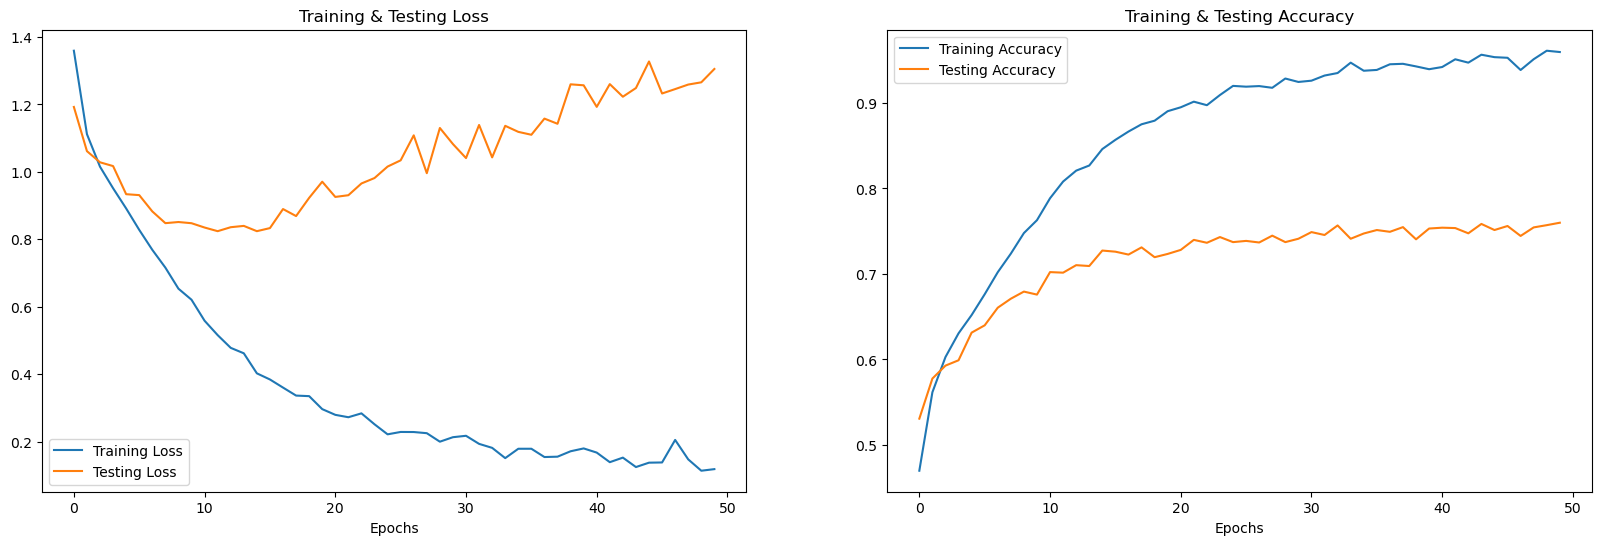

In [56]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [57]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

 77/286 [=======>......................] - ETA: 0s

2024-06-02 13:20:50.017876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - 1s 2ms/step


Predicted Labels Actual Labels
0              sad           sad
1            happy          fear
2          neutral       neutral
3          disgust       disgust
4            happy         happy
5          neutral           sad
6          disgust       disgust
7            happy         happy
8             fear          fear
9          neutral         happy

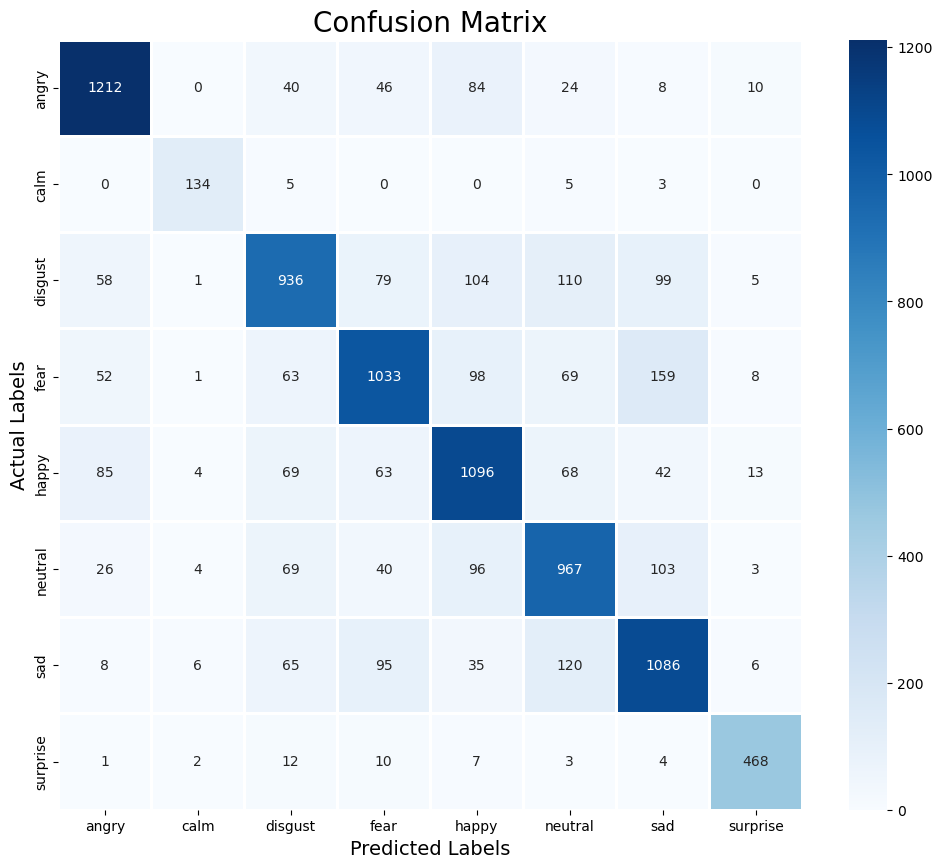

In [58]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.84      0.85      0.85      1424
        calm       0.88      0.91      0.90       147
     disgust       0.74      0.67      0.71      1392
        fear       0.76      0.70      0.73      1483
       happy       0.72      0.76      0.74      1440
     neutral       0.71      0.74      0.72      1308
         sad       0.72      0.76      0.74      1421
    surprise       0.91      0.92      0.92       507

    accuracy                           0.76      9122
   macro avg       0.79      0.79      0.79      9122
weighted avg       0.76      0.76      0.76      9122



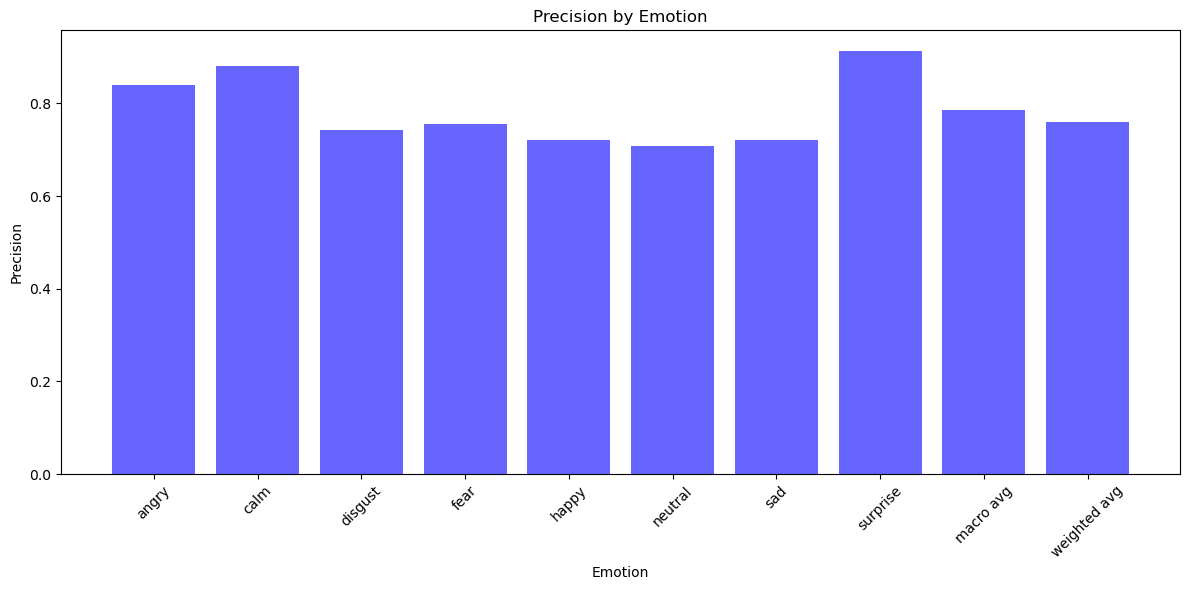

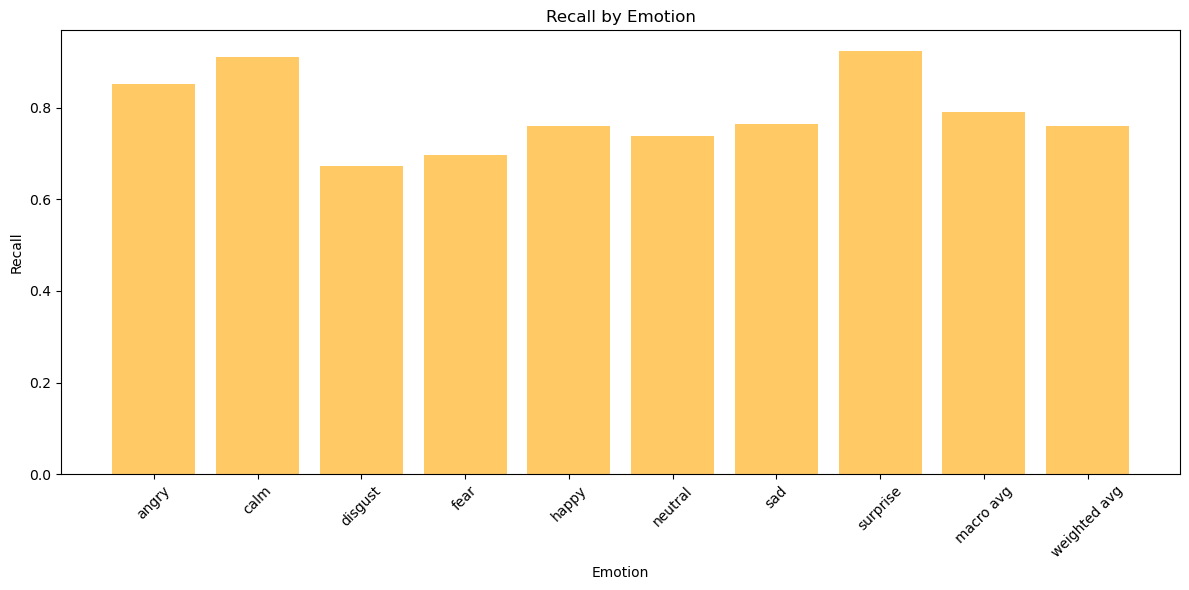

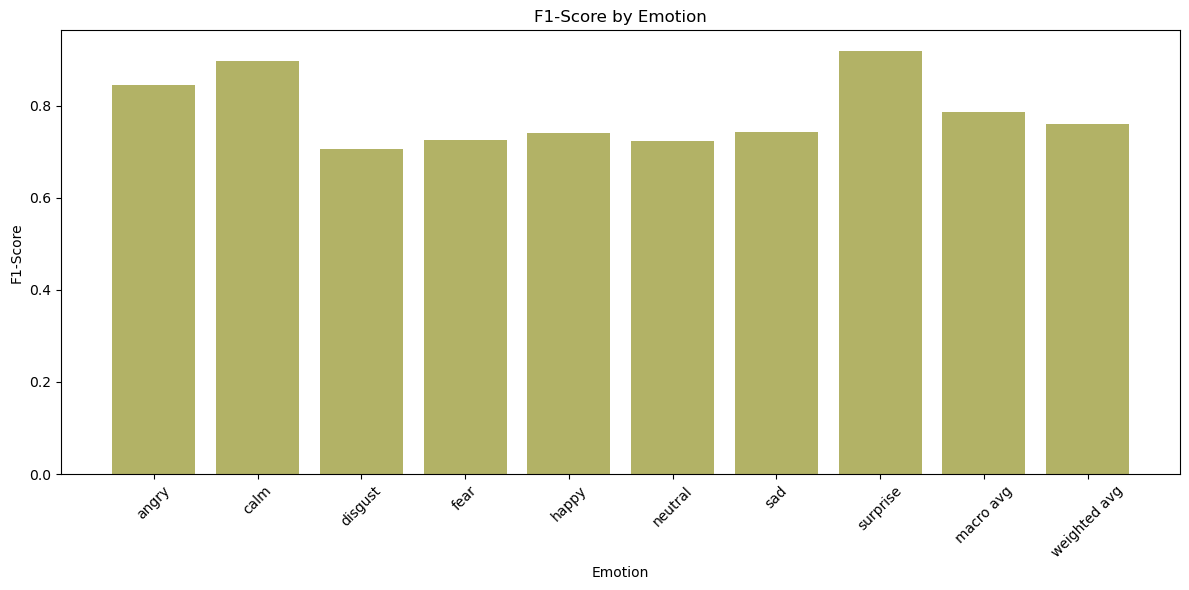

In [61]:
report = classification_report(y_test, y_pred, output_dict=True)
emotion_data = {
    "emotion": [],
    "precision": [],
    "recall": [],
    "f1-score": [],
    "support": []
}

for emotion, metrics in report.items():
    if isinstance(metrics, dict):
        emotion_data["emotion"].append(emotion)
        emotion_data["precision"].append(metrics.get("precision", 0))
        emotion_data["recall"].append(metrics.get("recall", 0))
        emotion_data["f1-score"].append(metrics.get("f1-score", 0))
        emotion_data["support"].append(metrics.get("support", 0))

df = pd.DataFrame(emotion_data)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df['emotion'], df['precision'], color='blue', alpha=0.6)
ax.set_xlabel('Emotion')
ax.set_ylabel('Precision')
ax.set_title('Precision by Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting recall
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df['emotion'], df['recall'], color='orange', alpha=0.6)
ax.set_xlabel('Emotion')
ax.set_ylabel('Recall')
ax.set_title('Recall by Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting F1-score
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df['emotion'], df['f1-score'], color='olive', alpha=0.6)
ax.set_xlabel('Emotion')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [62]:
report

{'angry': {'precision': 0.840499306518724,
  'recall': 0.851123595505618,
  'f1-score': 0.8457780879274249,
  'support': 1424},
 'calm': {'precision': 0.881578947368421,
  'recall': 0.9115646258503401,
  'f1-score': 0.8963210702341137,
  'support': 147},
 'disgust': {'precision': 0.7434471803018269,
  'recall': 0.6724137931034483,
  'f1-score': 0.7061486231610713,
  'support': 1392},
 'fear': {'precision': 0.7562225475841874,
  'recall': 0.6965610249494268,
  'f1-score': 0.7251667251667252,
  'support': 1483},
 'happy': {'precision': 0.7210526315789474,
  'recall': 0.7611111111111111,
  'f1-score': 0.7405405405405405,
  'support': 1440},
 'neutral': {'precision': 0.7079062957540263,
  'recall': 0.7392966360856269,
  'f1-score': 0.7232610321615556,
  'support': 1308},
 'sad': {'precision': 0.7220744680851063,
  'recall': 0.7642505277973258,
  'f1-score': 0.7425641025641025,
  'support': 1421},
 'surprise': {'precision': 0.9122807017543859,
  'recall': 0.9230769230769231,
  'f1-score': 0

### Predicting Gender and Emotion

In [238]:
dataset

Path     Sex   Emotion
0      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     angry
1      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female      fear
2      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female      fear
3      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     angry
4      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female   disgust
...                                                  ...     ...       ...
12157  /Users/gabrielcha/Documents/ser/data_savee/JE_...    male     angry
12158  /Users/gabrielcha/Documents/ser/data_savee/JE_...    male     angry
12159  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male   neutral
12160  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male  surprise
12161  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male  surprise

[12162 rows x 3 columns]

In [242]:
X, Y_emotion, Y_sex = [], [], []
for path, emotion, sex in zip(dataset.Path, dataset.Emotion, dataset.Sex):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y_emotion.append(emotion)
        Y_sex.append(sex)

In [245]:
ensemble_Features = pd.DataFrame(X)
ensemble_Features['labels_emotion'] = Y_emotion
ensemble_Features['labels_sex'] = Y_sex
ensemble_Features.to_csv('features.csv', index=False)
ensemble_Features

0         1         2         3         4         5         6  \
0      0.204540  0.519947  0.470245  0.491603  0.560526  0.548730  0.611754   
1      0.353927  0.692106  0.679201  0.707640  0.735085  0.717345  0.721191   
2      0.213317  0.510481  0.469152  0.498090  0.554262  0.556459  0.623730   
3      0.189815  0.559461  0.520419  0.483768  0.438286  0.392830  0.401268   
4      0.267836  0.687515  0.674725  0.650739  0.606905  0.589678  0.532692   
...         ...       ...       ...       ...       ...       ...       ...   
36481  0.068278  0.487927  0.486904  0.518272  0.563577  0.528844  0.465366   
36482  0.035218  0.420273  0.391346  0.419414  0.445050  0.406818  0.350023   
36483  0.021349  0.409676  0.451048  0.506771  0.551035  0.528723  0.578725   
36484  0.067057  0.528331  0.564499  0.632240  0.670117  0.647606  0.637693   
36485  0.026298  0.401437  0.443473  0.494779  0.552199  0.525564  0.562872   

              7         8         9  ...           154           155  \
0      0.547266  0.531048  0.607427  ...  4.037452e-03  4.854841e-03   
1      0.638624  0.637503  0.710741  ...  8.396025e-03  9.007170e-03   
2      0.536652  0.542395  0.641297  ...  1.567691e-03  2.468160e-03   
3      0.409626  0.440601  0.506417  ...  2.951628e-03  3.851316e-03   
4      0.542681  0.565831  0.631361  ...  2.954773e-03  3.864112e-03   
...         ...       ...       ...  ...           ...           ...   
36481  0.431581  0.521777  0.638770  ...  3.195724e-02  3.007923e-02   
36482  0.347140  0.430739  0.568061  ...  4.794030e-07  2.820406e-07   
36483  0.572316  0.467615  0.469997  ...  1.142653e-05  1.045971e-05   
36484  0.628927  0.591994  0.566017  ...  3.283402e-02  3.420073e-02   
36485  0.597115  0.507454  0.477009  ...  8.969327e-06  8.300623e-06   

                156           157           158           159           160  \
0      4.624050e-03  5.723318e-03  6.006947e-03  6.102506e-03  5.150126e-03   
1      8.457517e-03  9.728997e-03  1.046402e-02  1.009802e-02  9.468114e-03   
2      2.100010e-03  2.783756e-03  2.795735e-03  3.059233e-03  2.391162e-03   
3      3.153920e-03  2.964235e-03  2.586019e-03  2.761167e-03  1.653331e-03   
4      3.161657e-03  2.973872e-03  2.604806e-03  2.784978e-03  1.668544e-03   
...             ...           ...           ...           ...           ...   
36481  3.067593e-02  3.067895e-02  3.248877e-02  3.182271e-02  3.097837e-02   
36482  2.410397e-07  2.377171e-07  2.488742e-07  2.203630e-07  1.934513e-07   
36483  9.498662e-06  8.567799e-06  7.694576e-06  6.948766e-06  5.121959e-06   
36484  3.424603e-02  3.318302e-02  3.421079e-02  3.283147e-02  3.362673e-02   
36485  7.528229e-06  6.710855e-06  6.011765e-06  5.362213e-06  4.022111e-06   

                161  labels_emotion  labels_sex  
0      2.505069e-04           angry      female  
1      4.465369e-03           angry      female  
2      1.123824e-04           angry      female  
3      1.145745e-04            fear      female  
4      1.317539e-04            fear      female  
...             ...             ...         ...  
36481  2.996920e-02        surprise        male  
36482  1.220353e-07        surprise        male  
36483  1.648176e-06        surprise        male  
36484  3.189615e-02        surprise        male  
36485  1.327110e-06        surprise        male  

[36486 rows x 164 columns]

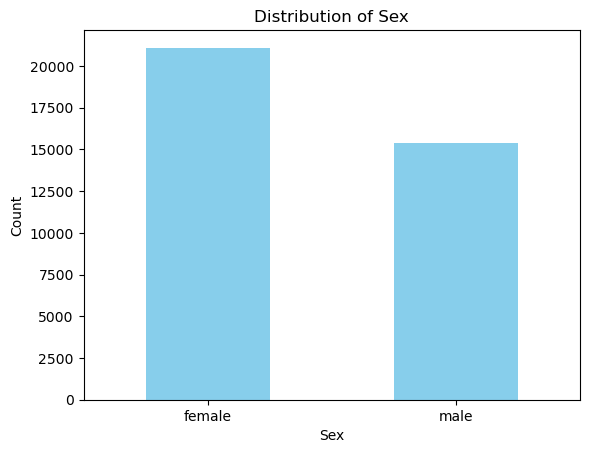

In [265]:
# Count the occurrences of each category
sex_counts = ensemble_Features['labels_sex'].value_counts()

# Create a bar chart
sex_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Sex')
plt.xticks(rotation=0)  # Rotates labels to be horizontal
plt.show()

In [260]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Prepare input features
X = ensemble_Features.iloc[:, :162].values  # assuming your features are the first 161 columns

# Prepare labels
label_encoder_emotion = LabelEncoder()
label_encoder_sex = LabelEncoder()

Y_emotion = label_encoder_emotion.fit_transform(ensemble_Features['labels_emotion'])
Y_sex = label_encoder_sex.fit_transform(ensemble_Features['labels_sex'])

# Convert labels to categorical (one-hot encoding)
Y_emotion = to_categorical(Y_emotion)
Y_sex = to_categorical(Y_sex)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, Y_emotion_train, Y_emotion_test, Y_sex_train, Y_sex_test = train_test_split(
    X_scaled, Y_emotion, Y_sex, test_size=0.2, random_state=42)


### Ensemble of Nerual Networks

In [374]:
# ensemble_Features
ensemble_Features = ensemble_Features.sample(frac=1).reset_index(drop=True) 
ensemble_Features

0         1         2         3         4         5         6  \
0      0.116310  0.639381  0.541249  0.444926  0.467997  0.475877  0.480271   
1      0.098250  0.288269  0.453638  0.316604  0.191528  0.259204  0.459469   
2      0.084189  0.540835  0.619902  0.553564  0.535034  0.527076  0.596129   
3      0.196924  0.794103  0.792300  0.770292  0.775499  0.801705  0.747820   
4      0.056871  0.491796  0.461614  0.467241  0.523119  0.642016  0.583304   
...         ...       ...       ...       ...       ...       ...       ...   
36481  0.141129  0.550747  0.634611  0.727353  0.703854  0.675124  0.628604   
36482  0.185345  0.731135  0.758556  0.695189  0.645033  0.672788  0.665341   
36483  0.096472  0.505595  0.549396  0.519175  0.569880  0.555210  0.464852   
36484  0.294235  0.732533  0.723532  0.764944  0.783355  0.797658  0.769553   
36485  0.116960  0.520076  0.598879  0.493612  0.359155  0.324958  0.471115   

              7         8         9  ...           154           155  \
0      0.496104  0.562871  0.552967  ...  1.305857e-05  2.205277e-05   
1      0.853248  0.618960  0.294889  ...  7.692805e-05  3.431690e-05   
2      0.583078  0.588682  0.707090  ...  1.838915e-09  1.749104e-09   
3      0.642461  0.673851  0.726393  ...  1.511879e-03  1.424686e-03   
4      0.558084  0.600138  0.578318  ...  1.110588e-09  1.035679e-09   
...         ...       ...       ...  ...           ...           ...   
36481  0.743858  0.694364  0.558621  ...  5.784484e-04  5.614455e-04   
36482  0.790009  0.728726  0.617264  ...  1.569238e-03  1.743536e-03   
36483  0.509551  0.544354  0.620769  ...  2.671509e-04  2.739807e-04   
36484  0.700050  0.747765  0.761896  ...  9.578635e-05  9.236962e-05   
36485  0.555290  0.572958  0.613706  ...  1.997656e-06  1.888382e-06   

                156           157           158           159           160  \
0      1.467923e-05  9.840445e-06  2.713199e-05  2.931779e-05  1.258847e-05   
1      3.864157e-05  3.305258e-05  2.801790e-05  1.966620e-05  1.327347e-05   
2      1.681595e-09  1.631108e-09  1.594981e-09  1.568713e-09  1.551893e-09   
3      1.533172e-03  1.619282e-03  1.537920e-03  1.442073e-03  1.431423e-03   
4      9.792558e-10  9.366435e-10  9.052928e-10  8.822724e-10  8.669360e-10   
...             ...           ...           ...           ...           ...   
36481  6.018362e-04  6.054074e-04  5.884713e-04  5.712007e-04  5.845319e-04   
36482  1.730762e-03  1.788970e-03  1.736729e-03  1.795862e-03  1.660532e-03   
36483  2.661667e-04  2.806505e-04  2.827433e-04  2.715236e-04  2.590834e-04   
36484  8.368788e-05  7.219942e-05  7.937600e-05  8.151071e-05  7.856095e-05   
36485  1.809507e-06  1.752179e-06  1.711968e-06  1.683267e-06  1.665123e-06   

                161  labels_emotion  labels_sex  
0      1.064025e-06             sad      female  
1      1.033644e-06         neutral      female  
2      1.541403e-09           angry        male  
3      1.456000e-03            fear        male  
4      8.574693e-10           happy      female  
...             ...             ...         ...  
36481  5.820101e-04           happy        male  
36482  1.793424e-03           happy        male  
36483  2.946126e-04           happy        male  
36484  5.047401e-05        surprise        male  
36485  1.653842e-06            fear      female  

[36486 rows x 164 columns]

In [375]:
# Prepare input features
X = ensemble_Features.iloc[:, :162].values  # All columns except the last two

# Prepare labels
label_encoder_emotion = LabelEncoder()
label_encoder_sex = LabelEncoder()

Y_emotion = label_encoder_emotion.fit_transform(ensemble_Features['labels_emotion'])
Y_sex = label_encoder_sex.fit_transform(ensemble_Features['labels_sex'])

# Convert labels to categorical (one-hot encoding)
Y_emotion = to_categorical(Y_emotion)
Y_sex = to_categorical(Y_sex)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [376]:
# Split the dataset into training and testing sets
X_train, X_test, Y_emotion_train, Y_emotion_test, Y_sex_train, Y_sex_test = train_test_split(
    X_scaled, Y_emotion, Y_sex, test_size=0.2, random_state=42)


In [377]:
# Find indices for male and female in the training data
male_indices = np.where(np.argmax(Y_sex_train, axis=1) == 1)[0]  # Assuming '1' is male
female_indices = np.where(np.argmax(Y_sex_train, axis=1) == 0)[0]  # Assuming '0' is female

# Create gender-specific training subsets for emotions
X_train_male = X_train[male_indices]
Y_emotion_train_male = Y_emotion_train[male_indices]

X_train_female = X_train[female_indices]
Y_emotion_train_female = Y_emotion_train[female_indices]


In [378]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.models import Model

def create_base_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(256, 5, padding='same', activation='relu')(input_layer)
    x = Conv1D(128, 5, padding='same', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPooling1D(pool_size=(8))(x)
    x = Conv1D(128, 5, padding='same', activation='relu')(x)
    x = Conv1D(128, 5, padding='same', activation='relu')(x)
    x = Flatten()(x)
    return x, input_layer

# Create the base model
x, input_layer = create_base_model((X_train.shape[1], 1))


In [379]:
def create_gender_model(base_model, num_genders):
    gender_output = Dense(num_genders, activation='softmax', name='gender_output')(base_model)
    model = Model(inputs=input_layer, outputs=gender_output)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate the gender model
gender_model = create_gender_model(x, Y_sex_train.shape[1])


In [380]:
def create_emotion_model(base_model, num_emotions):
    emotion_output = Dense(num_emotions, activation='softmax', name='emotion_output')(base_model)
    model = Model(inputs=input_layer, outputs=emotion_output)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate emotion models for male and female
emotion_model_male = create_emotion_model(x, Y_emotion_train.shape[1])
emotion_model_female = create_emotion_model(x, Y_emotion_train.shape[1])

In [381]:
gender_model.fit(X_train, Y_sex_train, epochs=10, batch_size=64, validation_data=(X_test, Y_sex_test))

Epoch 1/10


2024-05-04 18:59:54.743584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


457/457 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9060

2024-05-04 19:00:02.530813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


457/457 [==============================] - 9s 19ms/step - loss: 0.2185 - accuracy: 0.9060 - val_loss: 0.1343 - val_accuracy: 0.9494
Epoch 2/10
457/457 [==============================] - 8s 18ms/step - loss: 0.1240 - accuracy: 0.9519 - val_loss: 0.1160 - val_accuracy: 0.9544
Epoch 3/10
457/457 [==============================] - 8s 18ms/step - loss: 0.1047 - accuracy: 0.9597 - val_loss: 0.1070 - val_accuracy: 0.9556
Epoch 4/10
457/457 [==============================] - 8s 18ms/step - loss: 0.0895 - accuracy: 0.9655 - val_loss: 0.0968 - val_accuracy: 0.9618
Epoch 5/10
457/457 [==============================] - 8s 17ms/step - loss: 0.0813 - accuracy: 0.9687 - val_loss: 0.0877 - val_accuracy: 0.9651
Epoch 6/10
457/457 [==============================] - 8s 17ms/step - loss: 0.0713 - accuracy: 0.9731 - val_loss: 0.0831 - val_accuracy: 0.9678
Epoch 7/10
457/457 [==============================] - 8s 17ms/step - loss: 0.0665 - accuracy: 0.9750 - val_loss: 0.0650 - val_accuracy: 0.9744
Epoch 8/10

In [382]:
emotion_model_male.fit(X_train_male, Y_emotion_train_male, epochs=30, batch_size=64, validation_data=(X_test, Y_emotion_test))

Epoch 1/30


2024-05-04 19:01:16.088301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


193/193 [==============================] - ETA: 0s - loss: 1.4968 - accuracy: 0.4149

2024-05-04 19:01:19.595380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


193/193 [==============================] - 5s 23ms/step - loss: 1.4968 - accuracy: 0.4149 - val_loss: 1.7997 - val_accuracy: 0.3774
Epoch 2/30
193/193 [==============================] - 4s 20ms/step - loss: 1.2535 - accuracy: 0.5133 - val_loss: 1.9599 - val_accuracy: 0.3833
Epoch 3/30
193/193 [==============================] - 4s 20ms/step - loss: 1.1221 - accuracy: 0.5659 - val_loss: 2.0894 - val_accuracy: 0.4042
Epoch 4/30
193/193 [==============================] - 4s 20ms/step - loss: 1.0034 - accuracy: 0.6112 - val_loss: 2.2160 - val_accuracy: 0.4130
Epoch 5/30
193/193 [==============================] - 4s 21ms/step - loss: 0.9059 - accuracy: 0.6558 - val_loss: 2.7443 - val_accuracy: 0.4038
Epoch 6/30
193/193 [==============================] - 4s 20ms/step - loss: 0.8087 - accuracy: 0.6969 - val_loss: 3.1743 - val_accuracy: 0.4218
Epoch 7/30
193/193 [==============================] - 4s 21ms/step - loss: 0.7150 - accuracy: 0.7329 - val_loss: 3.3476 - val_accuracy: 0.4231
Epoch 8/30

In [383]:
emotion_model_female.fit(X_train_female, Y_emotion_train_female, epochs=30, batch_size=64, validation_data=(X_test, Y_emotion_test))

Epoch 1/30


2024-05-04 19:03:17.455968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


264/264 [==============================] - ETA: 0s - loss: 1.0613 - accuracy: 0.6066

2024-05-04 19:03:22.363531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


264/264 [==============================] - 6s 22ms/step - loss: 1.0613 - accuracy: 0.6066 - val_loss: 1.3090 - val_accuracy: 0.5338
Epoch 2/30
264/264 [==============================] - 5s 20ms/step - loss: 0.6987 - accuracy: 0.7315 - val_loss: 1.4179 - val_accuracy: 0.5512
Epoch 3/30
264/264 [==============================] - 5s 20ms/step - loss: 0.5532 - accuracy: 0.7882 - val_loss: 1.4885 - val_accuracy: 0.5771
Epoch 4/30
264/264 [==============================] - 5s 20ms/step - loss: 0.4424 - accuracy: 0.8356 - val_loss: 1.7141 - val_accuracy: 0.5788
Epoch 5/30
264/264 [==============================] - 5s 20ms/step - loss: 0.3654 - accuracy: 0.8645 - val_loss: 1.7092 - val_accuracy: 0.5847
Epoch 6/30
264/264 [==============================] - 5s 19ms/step - loss: 0.2971 - accuracy: 0.8898 - val_loss: 2.0052 - val_accuracy: 0.5874
Epoch 7/30
264/264 [==============================] - 5s 20ms/step - loss: 0.2601 - accuracy: 0.9051 - val_loss: 1.9932 - val_accuracy: 0.5919
Epoch 8/30

In [384]:
# Predict gender on the test data
gender_predictions_test = gender_model.predict(X_test)
gender_pred_classes_test = np.argmax(gender_predictions_test, axis=1)

# Predict emotions using the appropriate model based on predicted gender
emotion_predictions_test = np.zeros_like(Y_emotion_test)

for i in range(len(X_test)):
    if gender_pred_classes_test[i] == 1:  # '1' is male
        emotion_predictions_test[i] = emotion_model_male.predict(np.expand_dims(X_test[i], axis=0), verbose = 0)
    else:  # '0' is female
        emotion_predictions_test[i] = emotion_model_female.predict(np.expand_dims(X_test[i], axis=0),verbose = 0)

emotion_pred_classes_test = np.argmax(emotion_predictions_test, axis=1)

 71/229 [========>.....................] - ETA: 0s

2024-05-04 19:05:54.947548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


229/229 [==============================] - 1s 2ms/step


2024-05-04 19:05:55.502409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 19:05:55.597039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [385]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate Gender Model Accuracy
gender_accuracy = accuracy_score(np.argmax(Y_sex_test, axis=1), gender_pred_classes_test)
print(f"Gender Classification Accuracy: {gender_accuracy * 100:.2f}%")

# Evaluate Emotion Model Accuracy
emotion_accuracy = accuracy_score(np.argmax(Y_emotion_test, axis=1), emotion_pred_classes_test)
print(f"Emotion Classification Accuracy: {emotion_accuracy * 100:.2f}%")

# Additional metrics
print("\nGender Classification Report:")
print(classification_report(np.argmax(Y_sex_test, axis=1), gender_pred_classes_test))

print("Emotion Classification Report:")
print(classification_report(np.argmax(Y_emotion_test, axis=1), emotion_pred_classes_test))


Gender Classification Accuracy: 86.49%
Emotion Classification Accuracy: 61.88%

Gender Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4206
           1       0.83      0.86      0.84      3092

    accuracy                           0.86      7298
   macro avg       0.86      0.86      0.86      7298
weighted avg       0.87      0.86      0.87      7298

Emotion Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1137
           1       0.82      0.48      0.60       105
           2       0.54      0.55      0.55      1148
           3       0.49      0.64      0.55      1161
           4       0.61      0.58      0.59      1170
           5       0.67      0.55      0.60      1003
           6       0.67      0.60      0.63      1161
           7       0.88      0.81      0.85       413

    accuracy                           0.62 